In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
#!pip install tensorboard

In [ ]:
# copy file in colab
#!cp '/content/drive/MyDrive/Data/Idea Data/wpod_net_org.h5' ./

!cp '/content/drive/MyDrive/yIdea-Dataset-(ALL bike Included).zip' ./
!cp '/content/drive/MyDrive/wpod-net-input_modified.json' ./
!unzip -q 'yIdea-Dataset-(ALL bike Included).zip' -d ./
!mkdir "data"
!mkdir 'sRMSprop-WPOD'

In [ ]:
model_dir = "/content/data"

In [ ]:
import os
import glob
import random
import time
import json
import math
import shutil
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from __future__ import print_function, division
from skimage import io, transform
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

In [ ]:
PATH = './'
folder = "final-mixed"
json_file = 'final-mixed.json'
json_file2 = 'special.json'
height=120
width=480

test_size = 0.05

In [ ]:
os.listdir(model_dir)

[]

In [ ]:
with open(os.path.join(PATH, json_file), 'r') as f:
    label_data = json.load(f)

with open(os.path.join(PATH, json_file2), 'r') as f:
    label_data1 = json.load(f)

print("Total Number of train data point: {:,}".format(len(label_data)))
print("Total Number of test data point: {:,}".format(len(label_data1)))

Total Number of train data point: 8,900
Total Number of test data point: 118


In [ ]:
def resized_coords(coords, org_w, org_h, h=120, w=480):
    """
    function that returns the coordinates after reshaping the images
    """
    new = []
    for coord in coords:
        x, y = coord
        x = int(w*x/org_w)
        y = int(h*y/org_h)
        new.append([x,y])
    return new

In [ ]:
Names = []
Classes = []

for key, val in tqdm(label_data.items()):
    Names.append(key)
    if val.get('type') == 'colored':
        Classes.append(1)
    elif val.get('type') == 'gray':
        Classes.append(0)
    else:
        print(f"for file name `{key}`, unknown type")

100%|██████████| 8900/8900 [00:00<00:00, 1064756.71it/s]


In [ ]:
Classes.count(0), Classes.count(1)

(3044, 5856)

In [ ]:
train, val = train_test_split(Names, test_size = test_size, stratify = Classes, random_state = 42)
train_label, val_label, test_label = [], [], []


gtr, ctr = 0,0

for i in tqdm(train):
    coord = label_data[i]["coords"]
    org_w, org_h = label_data[i]["size"]["width"], label_data[i]["size"]["height"]
    coord = resized_coords(coord,org_w, org_h, height, width)
    train_label.append(coord)
   
    if Classes[Names.index(i)]==1:
        ctr += 1
    else:
        gtr += 1
        
print(f"\nIn train there are: {ctr}-colored and {gtr}-gray images. So % of gray is: {100*gtr/len(train)}%")

gtr, ctr = 0,0
for i in tqdm(val):
    coord = label_data[i]["coords"]
    org_w, org_h = label_data[i]["size"]["width"], label_data[i]["size"]["height"]
    coord = resized_coords(coord,org_w, org_h, height, width)
    val_label.append(coord)
    
    if Classes[Names.index(i)]==1:
        ctr += 1
    else:
        gtr += 1
        
print(f"\nIn validation there are: {ctr}-colored and {gtr}-gray images. So % of gray is: {100*gtr/len(val)}%")

for key in tqdm(label_data1.keys()):
    coord = label_data1[key]
    img = cv2.imread(os.path.join("./special-plates", key))
    org_h, org_w, _ = img.shape
    coord = resized_coords(coord,org_w, org_h, height, width)
    test_label.append(coord)

100%|██████████| 8455/8455 [00:00<00:00, 12245.69it/s]



In train there are: 5563-colored and 2892-gray images. So % of gray is: 34.20461265523359%


100%|██████████| 445/445 [00:00<00:00, 10775.67it/s]



In validation there are: 293-colored and 152-gray images. So % of gray is: 34.157303370786515%


100%|██████████| 118/118 [00:01<00:00, 87.68it/s]


In [ ]:
flatten_coords = lambda coords: [i[0] for i in coords] + [i[1] for i in coords]
reshape_coords = lambda coords: [[i,j] for i,j in zip(coords[:4], coords[4:])]

cols = ['coords-0-0', 'coords-1-0', 'coords-2-0', 'coords-3-0', 
        'coords-0-1', 'coords-1-1', 'coords-2-1', 'coords-3-1']

train_df = pd.DataFrame(columns = ["filename"])
train_df['filename']= train
train_df[cols]= np.array([flatten_coords(i) for i in train_label])

val_df = pd.DataFrame(columns = ["filename"])
val_df['filename']= val
val_df[cols]= np.array([flatten_coords(i) for i in val_label])

test_df = pd.DataFrame(columns = ["filename"])
test_df['filename']= list(label_data1.keys())
test_df[cols]= np.array([flatten_coords(i) for i in test_label])

assert len(train_df) == len(train)
assert len(val_df) == len(val)
assert len(test_df) == len(label_data1)

#coordinates = train_df.iloc[0, 1:]
#coordinates =  coordinates
#print(coordinates)

#train_df.to_csv('TRain.csv')
train_df.head()

,filename,coords-0-0,coords-1-0,coords-2-0,coords-3-0,coords-0-1,coords-1-1,coords-2-1,coords-3-1
0,69b98f9f3f547a57-0.png,43,436,415,43,2,14,110,103
1,19530-0.png,63,447,432,47,19,32,120,97
2,d7f1af9890d4f0b0-0.png,42,421,450,67,66,6,49,113
3,5dd346a3791a1054-0.png,15,469,469,15,16,50,116,76
4,1_uk_YY67SDZ_15856044.jpg,48,384,452,109,28,6,90,112


./final-mixed/1_uk_YY67SDZ_15856044.jpg
orginal shape:  (60, 70, 3)
current shape:  (120, 480, 3)
[[48, 28], [384, 6], [452, 90], [109, 112]]


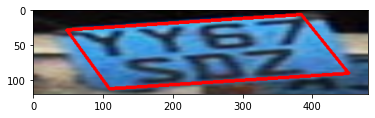

In [ ]:
index = 4
print(os.path.join(os.path.join(PATH, folder), train[index]))
img = cv2.imread(os.path.join(os.path.join(PATH, folder), train[index]))
print("orginal shape: ", img.shape)
img = cv2.resize(img, (width, height))
print("current shape: ", img.shape)

coords = train_label[index]
print(coords)
img = cv2.line(img, tuple(coords[0]), tuple(coords[1]), (0,0,255), 4)
img = cv2.line(img, tuple(coords[1]), tuple(coords[2]), (0,0,255), 4)
img = cv2.line(img, tuple(coords[2]), tuple(coords[3]), (0,0,255), 4)
img = cv2.line(img, tuple(coords[3]), tuple(coords[0]), (0,0,255), 4)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size."""

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        # image, landmarks = sample['image'], sample['coordinates']
        image = sample
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        

        # image = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        #landmarks = landmarks * [new_w / w, new_h / h]
        return image #{'image': image, 'coordinates': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['coordinates']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = np.reshape(image, (3, 120, 480))
        return {'image': torch.from_numpy(image),
                'coordinates': torch.from_numpy(landmarks)}

In [ ]:

class ResizeNormalize(object):

    def __init__(self, size, interpolation=Image.BICUBIC):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img = self.toTensor(img)
        # img.sub_(0.5).div_(0.5)
        return img



In [ ]:
class make_WPOD_dataset(Dataset):
    def __init__(self, df1, root_dir, output_size):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input_frame = df1
        self.root_dir = root_dir
        self.output_size = output_size
        # self.transform = transform
        self.interpolation = Image.BICUBIC
        self.toTensor = transforms.ToTensor() #torch transforms

    def __len__(self):
        return len(self.input_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
#cols = ['coords-0-0', 'coords-1-0', 'coords-2-0', 'coords-3-0', 
#        'coords-0-1', 'coords-1-1', 'coords-2-1', 'coords-3-1']
        img_name = os.path.join(self.root_dir, self.input_frame.iloc[idx, 0])
        # image = cv2.imread(img_name)
        img = Image.open(img_name)
        img = img.resize(self.output_size, self.interpolation)
        img = self.toTensor(img)

        coordinates = self.input_frame.iloc[idx, 1:]
        # coordinates = np.array([coordinates])
        # coordinates = coordinates.astype('float').flatten()
        coordinates = torch.FloatTensor(coordinates) #.flatten()
        
        sample = {'image': img, 'coordinates': coordinates}

        # if self.transform:
        #     sample = self.transform(sample)
        return sample

In [ ]:
wp = make_WPOD_dataset(df1 = train_df, root_dir = os.path.join(PATH, folder), output_size = ( width, height))

In [ ]:
train_df.iloc[3]

filename      5dd346a3791a1054-0.png
coords-0-0                        15
coords-1-0                       469
coords-2-0                       469
coords-3-0                        15
coords-0-1                        16
coords-1-1                        50
coords-2-1                       116
coords-3-1                        76
Name: 3, dtype: object

In [ ]:
wp[3]['coordinates']

tensor([ 15., 469., 469.,  15.,  16.,  50., 116.,  76.])

In [ ]:
wp[3]['image']

tensor([[[0.5098, 0.5059, 0.5059,  ..., 0.0941, 0.0941, 0.0941],
         [0.5059, 0.5020, 0.5020,  ..., 0.1176, 0.1176, 0.1176],
         [0.4980, 0.4941, 0.4941,  ..., 0.1765, 0.1765, 0.1765],
         ...,
         [0.5255, 0.5255, 0.5255,  ..., 0.5137, 0.4980, 0.4902],
         [0.5216, 0.5216, 0.5216,  ..., 0.5098, 0.4941, 0.4863],
         [0.5176, 0.5176, 0.5176,  ..., 0.5098, 0.4941, 0.4863]],

        [[0.5804, 0.5765, 0.5765,  ..., 0.1020, 0.1020, 0.1020],
         [0.5725, 0.5686, 0.5686,  ..., 0.1294, 0.1294, 0.1294],
         [0.5608, 0.5569, 0.5569,  ..., 0.1922, 0.1922, 0.1922],
         ...,
         [0.5804, 0.5804, 0.5804,  ..., 0.5490, 0.5333, 0.5255],
         [0.5804, 0.5804, 0.5804,  ..., 0.5490, 0.5333, 0.5255],
         [0.5804, 0.5804, 0.5804,  ..., 0.5490, 0.5333, 0.5255]],

        [[0.5373, 0.5333, 0.5333,  ..., 0.1176, 0.1176, 0.1176],
         [0.5333, 0.5294, 0.5294,  ..., 0.1490, 0.1490, 0.1490],
         [0.5294, 0.5255, 0.5255,  ..., 0.2196, 0.2196, 0.

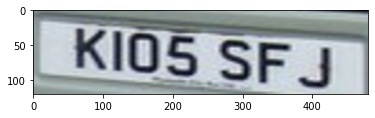

In [ ]:
plt.imshow(wp[3]['image'].permute(1, 2, 0))

In [ ]:
t = wp.__getitem__(3)

AttributeError: ignored

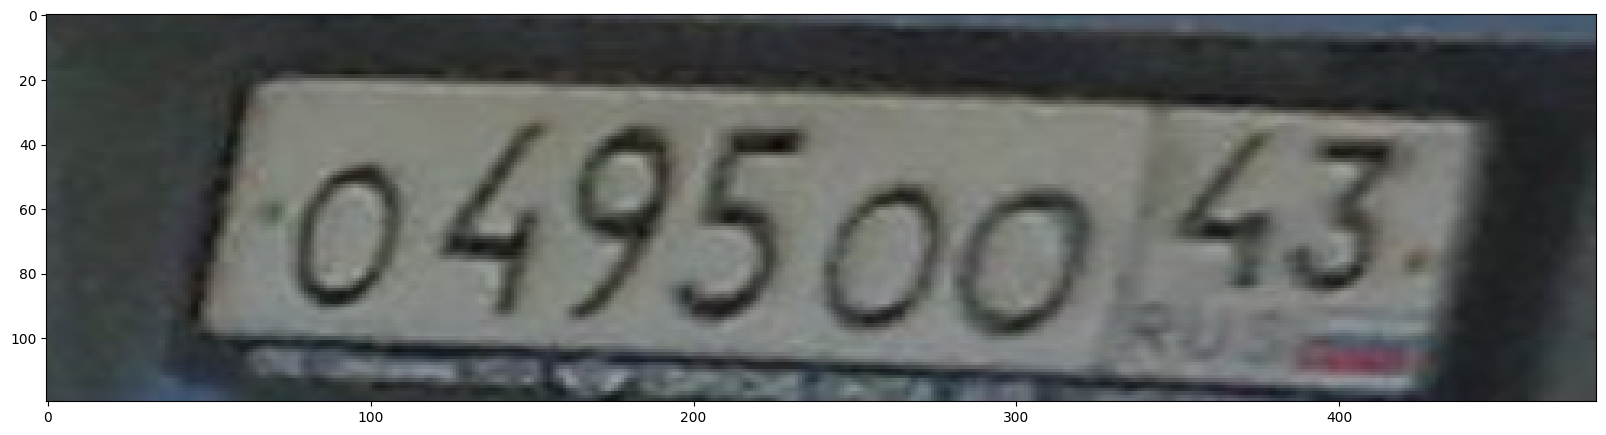

In [ ]:
rows = 1
cols = 8
axes=[]
fig=plt.figure(figsize = (20, 20), dpi=100)

for i in range(8):
    if wp[i]['image'].shape[0] == 1:
        image_numpy = wp[i]['image']
        image_numpy = np.tile(image_numpy, (3, 1, 1))
        plt.imshow(image_numpy.permute(1,2,0))
    else:
        plt.imshow(wp[i]['image'].permute(1,2,0))

In [ ]:
colzzz = ['filename', 'coords-0-0', 'coords-0-1', 'coords-1-0',
                  'coords-1-1',  'coords-2-0', 'coords-2-1', 'coords-3-0', 
                  'coords-3-1']

batch_size = 32
train_df = train_df.reindex(columns=colzzz)
val_df = val_df.reindex(columns=colzzz)

train_dataset = make_WPOD_dataset(df1 = train_df, root_dir = os.path.join(PATH, folder), output_size = (width, height))

val_dataset = make_WPOD_dataset(df1 = val_df, root_dir = os.path.join(PATH, folder), output_size = (width, height))

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                        shuffle=True, num_workers=4, pin_memory=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
for i in train_dataloader:
    print(i)

RuntimeError: ignored

TRAIN DATASET
0 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
TRAIN DATASET
1 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
TRAIN DATASET
2 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
TRAIN DATASET
3 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
TRAIN DATASET
4 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
(120, 480, 3)
<class 'numpy.ndarray'>
[ 42  19 426  16 432  98  44  94]
(120, 480, 3)
<class 'numpy.ndarray'>
[ 42  32 456  13 456  76  38  97]
(120, 480, 3)
<class 'numpy.ndarray'>
[ 68  10 447  40 423 103  41  71]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

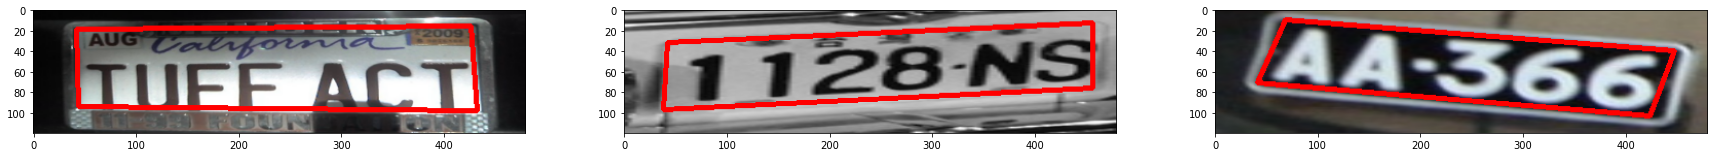

In [ ]:
colzzz = ['filename', 'coords-0-0', 'coords-0-1', 'coords-1-0',
                  'coords-1-1',  'coords-2-0', 'coords-2-1', 'coords-3-0', 
                  'coords-3-1']

batch_size = 32
train_df = train_df.reindex(columns=colzzz)
test_df = test_df.reindex(columns=colzzz)
val_df = val_df.reindex(columns=colzzz)
train_dataset = make_WPOD_dataset(df1 = train_df,
                                           root_dir = os.path.join(PATH, folder),
                                           transform=transforms.Compose([
                                               Rescale((height, width)),
                                               ToTensor()
                                           ]))

test_dataset = make_WPOD_dataset(test_df,
                                           root_dir = os.path.join('/content/special-plates/'),
                                           transform=transforms.Compose([
                                               Rescale((height, width)),
                                               ToTensor()
                                           ]))
val_dataset = make_WPOD_dataset(val_df,
                                           root_dir = os.path.join(PATH, folder),
                                           transform=transforms.Compose([
                                               Rescale((height, width)),
                                               ToTensor()
                                           ]))

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4, pin_memory=True)


def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['coordinates']
    #im_size = images_batch.size(2)
    #grid_border_size = 2
    #grid = utils.make_grid(images_batch)
    #plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.figure()
    fig, axis = plt.subplots(1,3,figsize=(30,10))
    #print(images_batch)
    for i in range(3):
        imgx = images_batch[i]
        imgx = imgx.cpu().detach().numpy()
        imgx = np.reshape(imgx, (120, 480, 3))
        imgx = 255*imgx
        print(imgx.shape)
        imgx = imgx.astype(np.uint8)
        print(type(imgx))
        #print(imgx)
        #imgx = cv2.cvtColor(imgx, cv2.COLOR_BGR2RGB)
        coords1 = landmarks_batch[i]
        coords1 = coords1.cpu().detach().numpy()
        coords1 = coords1.astype(int)
        print(coords1)
        #print(type(coords1))
        #print(coords)
        #coords = reshape_coords(coords)
        #coords1 = list(coords1)
        #print(coords1)
        imgx = cv2.line(imgx, tuple([coords1[0], coords1[1]]), tuple([coords1[2], coords1[3]]),
                        (255,0,0), 4)
        imgx = cv2.line(imgx, tuple([coords1[2], coords1[3]]), 
                       tuple([coords1[4], coords1[5]]) ,(255,0,0), 4)
        imgx = cv2.line(imgx, tuple([coords1[4], coords1[5]]), 
                        tuple([coords1[6], coords1[7]]), (255,0,0), 4)
        imgx = cv2.line(imgx, tuple([coords1[6], coords1[7]]),
                        tuple([coords1[0], coords1[1]]), (255,0,0), 4)
        axis[i].imshow(imgx)

for i_batch, sample_batched in enumerate(train_dataloader):
    print('TRAIN DATASET')
    print(i_batch, sample_batched['image'].size(),
          sample_batched['coordinates'].size())

    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.show()
        break

In [ ]:
#print(test_df)

# cc = 0
# print('total images=', len(val_df['filename']))
# for ii in val_df.index:
#   #print(test_df['filename'][ii])
#   try:
#     xxx = cv2.imread(os.path.join('/content/final-mixed/', str(val_df['filename'][ii])))
#     xxx.size
#   except AttributeError:
#     cc += 1
#     #print(test_df['filename'][ii])
#     #print('ERRR')
# print('Invalid images', cc) 

TEST DATASET
0 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
TEST DATASET
1 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
(120, 480, 3)
<class 'numpy.ndarray'>
[ 42  46 448  15 473  68  63  98]
(120, 480, 3)
<class 'numpy.ndarray'>
[  6  13 475   2 475 104   6 116]
(120, 480, 3)
<class 'numpy.ndarray'>
[ 40  42 445  18 468  77  56 102]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

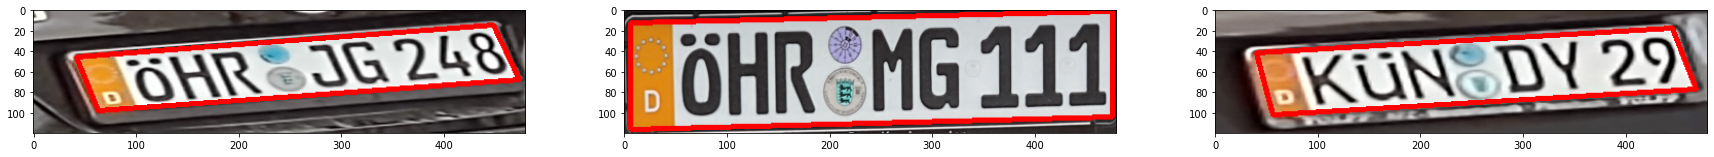

In [ ]:
# #from torch.utils.data import Dataset, DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)
# #print(test_dataloader)
# #print(list(dataloader2))

for i_batch, sample_batched in enumerate(test_dataloader):
    print('TEST DATASET')
    print(i_batch, sample_batched['image'].size(),
          sample_batched['coordinates'].size())

    # observe 4th batch and stop.
    if i_batch == 1:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.show()
        break

VAL DATASET
0 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
VAL DATASET
1 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
VAL DATASET
2 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
VAL DATASET
3 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
(120, 480, 3)
<class 'numpy.ndarray'>
[ 63  10 455   8 455  89  66  92]
(120, 480, 3)
<class 'numpy.ndarray'>
[ 90  27 477   8 466  74  76 107]
(120, 480, 3)
<class 'numpy.ndarray'>
[ 65   7 421  15 407 109  50  93]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

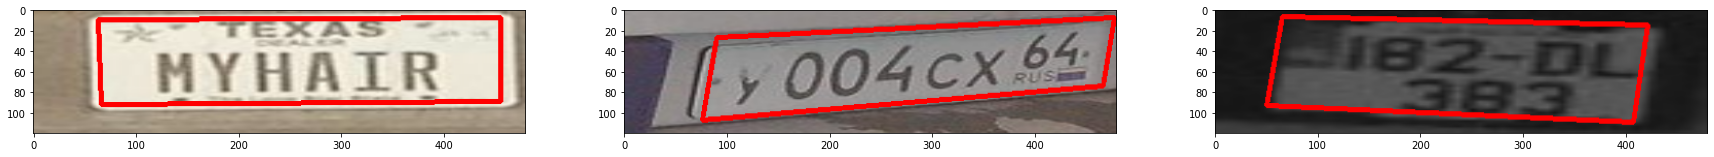

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)

for i_batch, sample_batched in enumerate(val_dataloader):
    print('VAL DATASET')
    print(i_batch, sample_batched['image'].size(),
          sample_batched['coordinates'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.show()
        break


In [ ]:
m = nn.ReLU(inplace=True)
input = torch.randn(2)
output = m(input)

print(input, output)

tensor([0.0000, 1.4958]) tensor([0.0000, 1.4958])


In [ ]:
#An implementation of CReLU - https://arxiv.org/abs/1603.05201

m = nn.ReLU(inplace=True)
input = torch.randn(2).unsqueeze(0)
output = torch.cat((m(input),m(-input)))
print(input, output)

tensor([[0.0000, 1.3026]]) tensor([[0.0000, 1.3026],
        [-0.0000, 0.0000]])


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("/content/PyTorch_Summary/")

class wpod_net(nn.Module):
    '''    
    def __init__(self):
        super(wpod_net, self).__init__()
        #self.Input_Layer = nn.Linear(120, 480, 3)
        self.conv_2d1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding = "same", dilation=1, groups=1, bias=True, padding_mode='replicate')
        self.batch_normalization_1 = nn.BatchNorm2d(num_features=16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv_2d2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), stride=(1,1), padding = "same", dilation=1, groups=1, bias=True, padding_mode='replicate')
        self.batch_normalization_2 = nn.BatchNorm2d(num_features=16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.max_pooling2d_1 = nn.MaxPool2d(kernel_size = 2, stride=2, padding = "same", dilation=1, return_indices=False, ceil_mode=False)
        self.conv_2d3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding = "same", dilation=1, groups=1, bias=True, padding_mode='replicate')
        self.batch_normalization_3 = nn.BatchNorm2d(num_features=32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        #self.conv_2d4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), stride=(1,1), padding = "same", dilation=1, groups=1, bias=True, padding_mode='replicate')
    '''
    def __init__(self):
        super(wpod_net, self).__init__()
        #self.Input_Layer = nn.Linear()
        self.conv2d_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding= "same", dilation=1, groups=1, bias=True)
        self.batch_normalization_1 = nn.BatchNorm2d(num_features=16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace= True)

        self.conv2d_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding= "same", dilation=1, groups=1, bias=True )
        self.batch_normalization_2 = nn.BatchNorm2d(num_features=16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)

        self.max_pooling2d_1= nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), padding = "same", dilation=1, return_indices=False, ceil_mode=False)
        
        self.conv2d_3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True )
        self.batch_normalization_3 = nn.BatchNorm2d(num_features=32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)

        self.conv2d_4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True )
        self.batch_normalization_4 = nn.BatchNorm2d(num_features=32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True )
        self.batch_normalization_5 = nn.BatchNorm2d(num_features=32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.max_pooling2d_2= nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), padding = "same", dilation=1, return_indices=False, ceil_mode=False)
        self.conv2d_6 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True)
        self.batch_normalization_6 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_7 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_8 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_9 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_10 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_10 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.max_pooling2d_3= nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), padding = "same", dilation=1, return_indices=False, ceil_mode=False)
        self.conv2d_11 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_11 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_12 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_13 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_13 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_14 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_14 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_15 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_15 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.max_pooling2d_4= nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), padding = "same", dilation=1, return_indices=False, ceil_mode=False)
        self.conv2d_16 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_16 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_17 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_17 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_18 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_18 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_19 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_19 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_20 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_20 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_21 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_21 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_22 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_23 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_23 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_24 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.batch_normalization_24 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_25 = nn.Conv2d(in_channels=128, out_channels=2, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.conv2d_26 = nn.Conv2d(in_channels=128, out_channels=6, kernel_size=(3, 3), stride=(1, 1), padding = "same", dilation=1, groups=1, bias=True, )
        self.flatten = nn.Flatten()
        self.output = nn.Linear(in_features=1680, out_features=8)
        
    def forward(self, x1):
        #x = self.Input_Layer(x)
        #y = torch.randn(1, 3, 120, 480)
        #x1 = self.Input_Layer(x1)
# Block _1
        x1 = self.conv2d_1(x1)
        x1 = self.batch_normalization_1(x1)                 
        x1 = self.relu(x1)
# Block _2
        x1 = self.conv2d_2(x1)
        x1 = self.batch_normalization_2(x1)
        x1 = self.relu(x1)
        x1 = self.max_pooling2d_1(x1)
# Block _3
        x1 = self.conv2d_3(x1)
        x1 = self.batch_normalization_3(x1)
        x1 = self.relu(x1)
#Block 4
        x2 = self.conv2d
        x2 = self.batch_normalization_5(self.conv2d_5(F.relu(self.batch_normalization_4(self.conv2d_4(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(self.batch_normalization_6(self.conv2d_6(self.max_pooling2d_2(F.relu(addition)))))
        x2 = self.batch_normalization_8(self.conv2d_8(F.relu(self.batch_normalization_7(self.conv2d_7(x1)))))
        x1 = F.relu(x1 + x2)
        x2 = self.batch_normalization_10(self.conv2d_10(F.relu(self.batch_normalization_9(self.conv2d_9(x1)))))
        addition = x1 + x2  #torch.add(x1, x2)
        x1 = F.relu(self.batch_normalization_11(self.conv2d_11(self.max_pooling2d_3(F.relu(addition)))))
        x2 = self.batch_normalization_13(self.conv2d_13(F.relu(self.batch_normalization_12(self.conv2d_12(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(addition)
        x2 = self.batch_normalization_15(self.conv2d_15(F.relu(self.batch_normalization_14(self.conv2d_14(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(self.batch_normalization_16(self.conv2d_16(self.max_pooling2d_4(F.relu(addition)))))
        x2 = self.batch_normalization_18(self.conv2d_18(F.relu(self.batch_normalization_17(self.conv2d_17(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(addition)
        x2 = self.batch_normalization_20(self.conv2d_20(F.relu(self.batch_normalization_19(self.conv2d_19(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(addition)
        x2 = self.batch_normalization_22(self.conv2d_22(F.relu(self.batch_normalization_21(self.conv2d_21(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(addition)
        x2 = self.batch_normalization_24(self.conv2d_24(F.relu(self.batch_normalization_23(self.conv2d_23(x1)))))
        addition = F.relu(x1 + x2)
        x1 = self.conv2d_25(addition)
        x2 = self.conv2d_26(addition)
        concatenate_1 = torch.cat((x1, x2), 1)
        x1 = self.flatten(concatenate_1)
        x1 = self.output(x1)
        return x1
        
#t1 = torch.zeros(1, 3, 120, 480, dtype=torch.float, requires_grad=True)
wpod_model = wpod_net()

#wpod_out = wpod_net()
#summary(wpod_model, (3, 120, 480))

'''
optimizer = torch.optim.SGD(wpod_model.parameters(), lr=0.001, momentum=0.9)
print("Model's state_dict:")
for param_tensor in wpod_model.state_dict():
    print(param_tensor, "\t", wpod_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

writer.add_graph(wpod_model, t1)
writer.close()
print('Written to tensorboard 2')
'''

'\noptimizer = torch.optim.SGD(wpod_model.parameters(), lr=0.001, momentum=0.9)\nprint("Model\'s state_dict:")\nfor param_tensor in wpod_model.state_dict():\n    print(param_tensor, "\t", wpod_model.state_dict()[param_tensor].size())\n\n# Print optimizer\'s state_dict\nprint("Optimizer\'s state_dict:")\nfor var_name in optimizer.state_dict():\n    print(var_name, "\t", optimizer.state_dict()[var_name])\n\nwriter.add_graph(wpod_model, t1)\nwriter.close()\nprint(\'Written to tensorboard 2\')\n'

In [ ]:
#!mkdir 'sRMSprop-WPOD'

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = optim.RMSprop(wpod_model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
fil1 = open('/content/sRMSprop-WPOD/WPOD-RMSprop-PyTorch.csv', 'w+')
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:

def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
print(device)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

#train_dataloader = DeviceDataLoader(train_dataloader,device)
#val_dataloader = DeviceDataLoader(val_dataloader,device)
wpod_model = to_device(wpod_model, device)

cuda


In [ ]:
xdataloaders = {'train': train_dataloader,
                'val' : val_dataloader}
xdataset_sizes = {'train':len(train_dataloader),
                 'val': len(val_dataloader)}
import copy
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    best_acc = 0.0
    for epoch in range(num_epochs):
        t1 = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                wpod_model.train()  # Set model to training mode
            else:
                wpod_model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, xdata in enumerate(xdataloaders[phase], 0):
                inputs = xdata['image'].float().cuda() 
                labels = xdata['coordinates'].float().cuda()
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = wpod_model(inputs)
                    _, preds = torch.max(outputs, 1, keepdim=True)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / xdataset_sizes[phase]
            epoch_acc = running_corrects.double() / xdataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(wpod_model.state_dict())
        t2 = time.time()
        print('time taken =', t2 - t1, 'sec')
        #fil1.writelines(str(epoch)+','+str(epoch_loss)+','+str(epoch_acc)+'\n')
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        writer.add_scalar("Accuracy/train", epoch_acc, epoch)

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    wpod_model.load_state_dict(best_model_wts)
    return wpod_model

#print('Finished Training for 140 epochs')


In [ ]:

model_ft = train_model(wpod_model, criterion, optimizer, exp_lr_scheduler, num_epochs=140)
writer.flush()
fil1.close()
torch.save(model_ft, '/content/sRMSprop-WPOD/mWPOD_RMSProp.pth')
torch.save(model_ft.state_dict(), '/content/sRMSprop-WPOD/weights_WPOD_RMSProp.pth')
print('Saved model successfully')


Epoch 0/139
----------


RuntimeError: ignored

In [ ]:
import json

In [ ]:
with open("./wpod_json_format.json", 'r') as f :
    j = json.load(f)

In [ ]:
j.keys(
    
)

dict_keys(['class_name', 'config', 'keras_version', 'backend'])

In [ ]:
len(j["config"]['layers'])

91

In [ ]:
j["config"]['layers'][0:4]

[{'class_name': 'InputLayer',
  'config': {'batch_input_shape': [None, 120, 480, 3],
   'dtype': 'float32',
   'name': 'new_input',
   'ragged': False,
   'sparse': False},
  'inbound_nodes': [],
  'name': 'new_input'},
 {'class_name': 'Conv2D',
  'config': {'activation': 'linear',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'data_format': 'channels_last',
   'dilation_rate': [1, 1],
   'dtype': 'float32',
   'filters': 16,
   'groups': 1,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': [3, 3],
   'name': 'conv2d_1',
   'padding': 'same',
   'strides': [1, 1],
   'trainable': True,
   'use_bias': True},
  'inbound_nodes': [[['new_input', 0, 0, {}]]],
  'name': 'conv2d_1'},
 {'class_name

In [ ]:
for i, layer in enumerate(j["config"]['layers']):
    print(f'{i}. {layer["class_name"]}')

0. InputLayer
1. Conv2D
2. BatchNormalization
3. Activation
4. Conv2D
5. BatchNormalization
6. Activation
7. MaxPooling2D
8. Conv2D
9. BatchNormalization
10. Activation
11. Conv2D
12. BatchNormalization
13. Activation
14. Conv2D
15. BatchNormalization
16. Add
17. Activation
18. MaxPooling2D
19. Conv2D
20. BatchNormalization
21. Activation
22. Conv2D
23. BatchNormalization
24. Activation
25. Conv2D
26. BatchNormalization
27. Add
28. Activation
29. Conv2D
30. BatchNormalization
31. Activation
32. Conv2D
33. BatchNormalization
34. Add
35. Activation
36. MaxPooling2D
37. Conv2D
38. BatchNormalization
39. Activation
40. Conv2D
41. BatchNormalization
42. Activation
43. Conv2D
44. BatchNormalization
45. Add
46. Activation
47. Conv2D
48. BatchNormalization
49. Activation
50. Conv2D
51. BatchNormalization
52. Add
53. Activation
54. MaxPooling2D
55. Conv2D
56. BatchNormalization
57. Activation
58. Conv2D
59. BatchNormalization
60. Activation
61. Conv2D
62. BatchNormalization
63. Add
64. Activati